In [133]:
import numpy as np
from typing import Tuple
import torch
import pandas as pd

from torch.nn.functional import mse_loss, cross_entropy, one_hot
import matplotlib.pyplot as plt

# LAB2

# 1.1 Implement gradient-based factorisation using PyTorch's AD

In [134]:
def gd_factorise_ad(A: torch.Tensor, rank: int, num_epochs: int=1000, lr:float=0.01) -> Tuple[torch.Tensor, torch.Tensor]:
    U = torch.rand(A.shape[0], rank, requires_grad=True)
    V = torch.rand(A.shape[1], rank, requires_grad=True)
    
    for e in range(num_epochs):
        U.grad = torch.zeros_like(U)
        V.grad = torch.zeros_like(V)
        A_ = U @ V.t()
        err = torch.nn.functional.mse_loss(A, A_, reduction='sum')
        err.backward()
        with torch.no_grad():
            U -= lr * U.grad
            V -= lr * V.grad
    return U, V


# 1.2 Factorise and compute reconstruction error on real data

In [135]:
df = pd.read_csv('https://archive.ics.uci.edu/ml/machine-learning-databases' + '/iris/iris.data', header=None)
data = torch.tensor(df.iloc[:, [0,1,2,3]].values)
data = data - data.mean(dim=0)
data = data.to(torch.float)

In [136]:
U, V = gd_factorise_ad(data, 2)

sgd_loss = mse_loss(data, U@V.t())

In [137]:
U, S, Vh = torch.linalg.svd(data)
S = torch.diag(S)
data_ = U[:, :2] @ S[:2, :2] @ Vh[:2, :]

svd_loss = mse_loss(data, data_)

print("reconsturction loss by svd: ", svd_loss.item(), " reconstruction loss by sgd: ", sgd_loss.item())

reconsturction loss by svd:  0.025381390005350113  reconstruction loss by sgd:  0.025382308289408684


# 1.3 Compare aginst PCA

In [138]:
sgd_U, _ = gd_factorise_ad(data, 2)
svd_U, _, _ = torch.linalg.svd(data, full_matrices=True)

In [139]:
svd_pc = svd_U[:, :2]
sgd_pc = sgd_U
svd_pc = np.array(svd_pc[:, :2].detach().numpy())
sgd_pc = np.array(sgd_pc.detach().numpy())


print(np.dot(svd_U[:, 0], svd_U[:, 1]), np.dot(sgd_pc[:, 0], sgd_pc[:, 1]))

8.6613e-08 21.22606


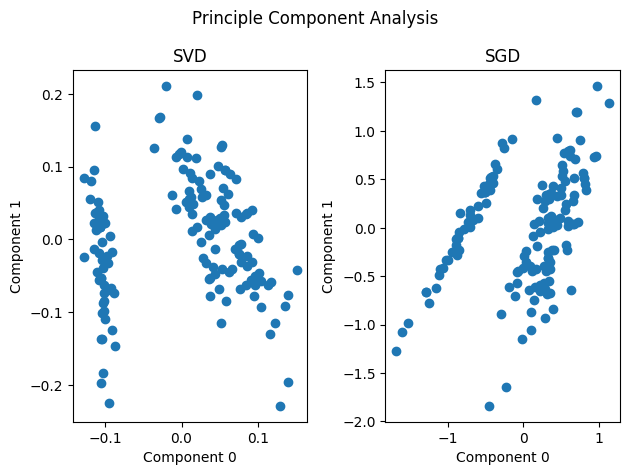

In [140]:
fig, axes = plt.subplots(1, 2)
fig.suptitle("Principle Component Analysis")
axes[0].set_title('SVD')
axes[0].scatter(svd_pc[:, 0], svd_pc[:, 1])
axes[0].set_xlabel('Component 0')
axes[0].set_ylabel('Component 1')
axes[1].scatter(sgd_pc[:,0], sgd_pc[:, 1])
axes[1].set_title('SGD')
axes[1].set_xlabel('Component 0')
axes[1].set_ylabel('Component 1')
fig.tight_layout()

# 2 MLP

In [141]:
df = pd.read_csv('https://archive.ics.uci.edu/ml/machine-learning-databases' + '/iris/iris.data', header=None)
df = df.sample(frac=1) #s h u f f l e

In [142]:
mapping = {k : v for v , k in enumerate(df[4].unique())}
df[5] = df[4].map(mapping)

In [143]:
alldata = torch.tensor(df.iloc[:, [0,1,2,3]].values, dtype=torch.float)
alldata = (alldata - alldata.mean(dim=0)) / alldata.var(dim=0)

In [144]:
targets_tr = torch.tensor(df.iloc[:100, 5].values, dtype=torch.long)
targets_va = torch.tensor(df.iloc[100:, 5].values, dtype=torch.long)
data_tr = alldata[:100]
data_va = alldata[100:]

# 2.1 Implement the MLP

In [184]:
class simple_mlp:
    def __init__(self):
        self.W1 = torch.randn(4, 12, requires_grad=True)
        self.W2 = torch.randn(12, 3, requires_grad=True)
        self.b1 = torch.zeros(1, requires_grad=True)
        self.b2 = torch.zeros(1, requires_grad=True)
        
        self.train_losses = []
        self.validation_losses = []
    
    def __forward__(self, inputs):
        return torch.relu(inputs @ self.W1 + self.b1) @ self.W2 + self.b2
    
    def compute_loss(self, data, targets):
        logits = self.__forward__(data)
        targets = one_hot(targets, num_classes=3).float()
        loss = cross_entropy(logits, targets, reduction='mean')
        return loss
    
    @torch.no_grad()
    def validate_loss(self, data, targets):
        loss_total = []
        for x, y in zip(data, targets):
            pred = self.__forward__(x)
            loss = self.compute_loss(data, targets)
            loss_total.append(loss.item())
        self.validation_losses.append(np.mean(loss_total))
      
    @torch.no_grad()
    def zero_grad(self):
        self.W1.detach()
        self.W2.detach()
        self.b1.detach()
        self.b2.detach()
        self.W1.grad.zero_()
        self.W2.grad.zero_()
        self.b1.grad.zero_()
        self.b2.grad.zero_()
           
    def train_one_epoch(self, data, targets, lr=0.01):
        losses = []
        for x, y in zip(data, targets):
            loss = self.compute_loss(x, y)
            losses.append(loss.item())
            loss.backward()
            with torch.no_grad():
                self.W1 -= lr * self.W1.grad
                self.W2 -= lr * self.W2.grad
                self.b1 -= lr * self.b1.grad
                self.b2 -= lr * self.b2.grad
            self.zero_grad()
        self.train_losses.append(np.mean(losses))
        

In [185]:
mlp = simple_mlp()

In [186]:
for epoch in range(100):
    mlp.train_one_epoch(data_tr, targets_tr)
    mlp.validate_loss(data_va, targets_va)

Text(0, 0.5, 'loss')

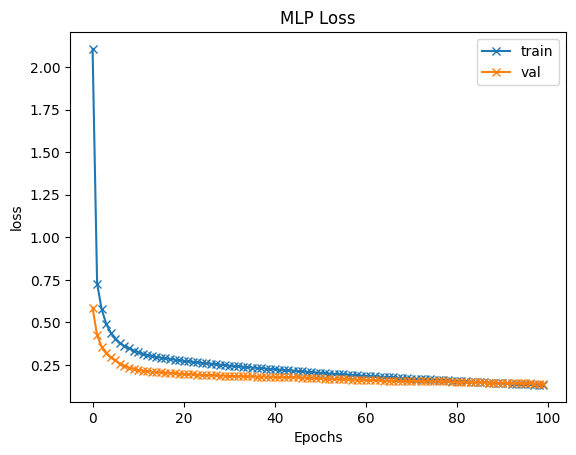

In [187]:
plt.plot(np.arange(100), mlp.train_losses, label='train', marker='x')
plt.plot(np.arange(100), mlp.validation_losses, label='val', marker='x')
plt.legend()
plt.title('MLP Loss')
plt.xlabel('Epochs')
plt.ylabel('loss')

# e

In [188]:
for test in range(100):
    v_loss = []
    t_loss = []
    mlp = simple_mlp()
    print("test: ", test)
    for epoch in range(100):
        mlp.train_one_epoch(data_tr, targets_tr)
        mlp.validate_loss(data_va, targets_va)
        t_loss.append(mlp.train_losses[-1])
        v_loss.append(mlp.validation_losses[-1])

test:  0
test:  1
test:  2
test:  3
test:  4
test:  5
test:  6
test:  7
test:  8
test:  9
test:  10
test:  11
test:  12
test:  13
test:  14
test:  15
test:  16
test:  17
test:  18
test:  19
test:  20
test:  21
test:  22
test:  23
test:  24
test:  25
test:  26
test:  27
test:  28
test:  29
test:  30
test:  31
test:  32
test:  33
test:  34
test:  35
test:  36
test:  37
test:  38
test:  39
test:  40
test:  41
test:  42
test:  43
test:  44
test:  45
test:  46
test:  47
test:  48
test:  49
test:  50
test:  51
test:  52
test:  53
test:  54
test:  55
test:  56
test:  57
test:  58
test:  59
test:  60
test:  61
test:  62
test:  63
test:  64
test:  65
test:  66
test:  67
test:  68
test:  69
test:  70
test:  71
test:  72
test:  73
test:  74
test:  75
test:  76
test:  77
test:  78
test:  79
test:  80
test:  81
test:  82
test:  83
test:  84
test:  85
test:  86
test:  87
test:  88
test:  89
test:  90
test:  91
test:  92
test:  93
test:  94
test:  95
test:  96
test:  97
test:  98
test:  99


Text(0, 0.5, 'p(loss) (%)')

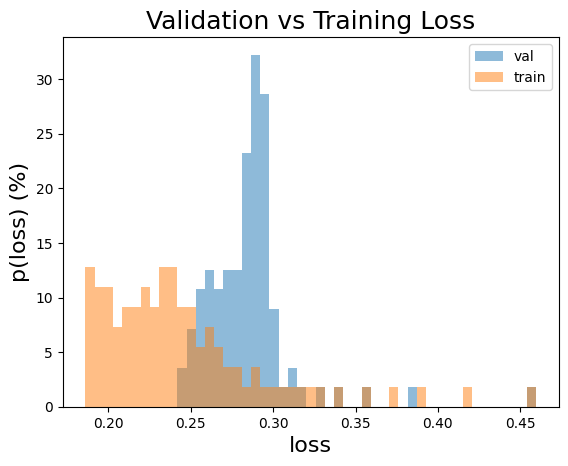

In [201]:

bins = np.linspace(min(t_loss), max(v_loss), 50)
plt.hist(np.array(v_loss), bins=bins, density=True, alpha=0.5, label='val')
plt.hist(np.array(t_loss), bins=bins, density=True, alpha=0.5, label='train')
plt.legend()
plt.title("Validation vs Training Loss", fontsize=18)
plt.xlabel('loss', fontsize=16)
plt.ylabel('p(loss) (%)', fontsize=16)

In [190]:
print("train loss mean: {loss:.3f}   train loss std:  {std:3f}".format(loss=np.mean(t_loss), std=np.std(t_loss)))
print("val loss mean: {loss:.3f}   val loss std:  {std:3f}".format(loss=np.mean(v_loss), std=np.std(v_loss)))

train loss mean: 0.263   train loss std:  0.163756
val loss mean: 0.286   val loss std:  0.027719
